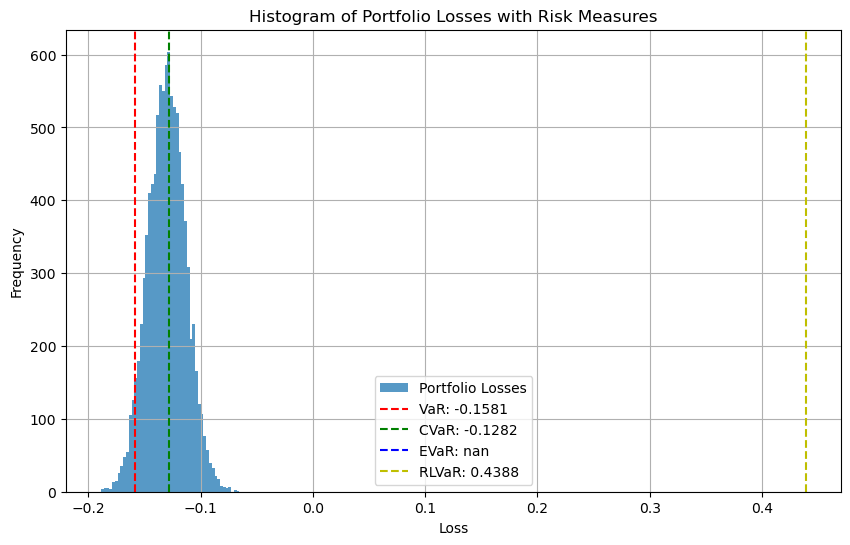

HRP Weights: [1 1]
VaR: -0.15808867937585816
CVaR: -0.12824504338823095
EVaR: nan
RLVaR: 0.43878404037668584


In [11]:
#This code provides a basic OOP-style implementation of the risk measures and their computation for a synthetic portfolio. You can replace the synthetic data with your actual portfolio data and adjust the parameters as needed.


import numpy as np
import scipy.cluster.hierarchy as sch
from scipy.stats import norm
import matplotlib.pyplot as plt

class Portfolio:
    def __init__(self, weights, returns, cov_matrix):
        self.weights = weights
        self.returns = returns
        self.cov_matrix = cov_matrix

    def simulate_returns(self, num_simulations=10000):
        return np.random.multivariate_normal(self.returns, self.cov_matrix, num_simulations)

class RiskMeasures:
    def VaR(self, losses, alpha=0.05):
        return np.percentile(losses, alpha * 100)

    def CVaR(self, losses, alpha=0.05):
        var = self.VaR(losses, alpha)
        return np.mean(losses[losses > var])

    def EVaR(self, losses, alpha=0.05):
        var = self.VaR(losses, alpha)
        positive_losses = losses[losses > 0]
        if len(positive_losses) == 0:
            return np.nan
        return np.exp(np.mean(np.log(positive_losses[positive_losses > var])))
       

    def RLVaR(self, losses, alpha=0.05):
        var = self.VaR(losses, alpha)
        conditional_losses = losses[losses > var]
        rlvar = var + (1 / (alpha * len(conditional_losses))) * np.sum(conditional_losses - var)
        return rlvar

class HRP:
    def __init__(self, cov_matrix):
        self.cov_matrix = cov_matrix

    def get_quasi_diagonal(self, link):
        return sch.dendrogram(link, no_plot=True)["leaves"]

    def allocate(self):
        link = sch.linkage(self.cov_matrix, "single")
        sort_ix = self.get_quasi_diagonal(link)
        hrp_weights = self.recursive_bisection(self.cov_matrix, sort_ix)
        return hrp_weights

    def recursive_bisection(self, cov, sort_ix):
        w = np.array([1])
        if len(sort_ix) > 1:
            split = len(sort_ix) // 2
            left = sort_ix[:split]
            right = sort_ix[split:]
            w_left = self.recursive_bisection(cov, left)
            w_right = self.recursive_bisection(cov, right)
            w = np.concatenate([w_left, w_right])
        return w

# Simulate some synthetic portfolio data
np.random.seed(42)
weights = np.array([0.4, 0.6])
returns = np.array([0.05, 0.08])
cov_matrix = np.array([[0.0001, 0.00003], [0.00003, 0.00012]])

# Compute HRP weights
hrp = HRP(cov_matrix)
hrp_weights = hrp.allocate()

# Adjust portfolio to use HRP weights
portfolio = Portfolio(hrp_weights, returns, cov_matrix)
simulated_returns = portfolio.simulate_returns()

# Compute portfolio losses
portfolio_losses = -np.dot(simulated_returns, hrp_weights)

# Compute risk measures
risk_measures = RiskMeasures()
var = risk_measures.VaR(portfolio_losses)
cvar = risk_measures.CVaR(portfolio_losses)
evar = risk_measures.EVaR(portfolio_losses)
rlvar = risk_measures.RLVaR(portfolio_losses)

# Plot histogram with risk measures
plt.figure(figsize=(10, 6))
plt.hist(portfolio_losses, bins=50, alpha=0.75, label="Portfolio Losses")
plt.axvline(x=var, color='r', linestyle='--', label=f"VaR: {var:.4f}")
plt.axvline(x=cvar, color='g', linestyle='--', label=f"CVaR: {cvar:.4f}")
plt.axvline(x=evar, color='b', linestyle='--', label=f"EVaR: {evar:.4f}")
plt.axvline(x=rlvar, color='y', linestyle='--', label=f"RLVaR: {rlvar:.4f}")
plt.title("Histogram of Portfolio Losses with Risk Measures")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

print(f"HRP Weights: {hrp_weights}")
print(f"VaR: {var}")
print(f"CVaR: {cvar}")
print(f"EVaR: {evar}")
print(f"RLVaR: {rlvar}")
